<center><img src="pictures/style/title.png" height=450; width=450;><center>

<center>https://arxiv.org/pdf/1508.06576.pdf<center>
    link to the paper

**So, the idea behind this paper is to have a content image that we feed to the model and another image, typically a painting that we also feed the model. The resulting image has the content of the image we've provided and the style of the painting.** </br>
- **As it could be seen from the image below, we could get different representation for content and style at different layers. We're working with vgg19 here. At the lower level layers we can see that when the style image is forwarded, the style is not clearly seen. It takes another layer or two in order for this to happen, eventually we end up with something like exactly the same style as we have in the painting.** </br>

- **The same thing for the content, but a little bit different. We have quite clear representation of the content even in lower level layers of the model. But as the layers keep on adding, the content image becomes more and more unrecognizable.**

<center><img src="pictures/style/style_architecture.png" height=500; width=500><center>

In [45]:
import torch
import torch.nn as nn
from PIL import Image
import cv2
import PIL
from torchvision.models import vgg19
import urllib
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

In [28]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

**We're going to kick things off with the creation of the model that we need. It's pretrained vgg19, but we're going to collect only feature representations from it(at a certain layer), not its output.**

<enter><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSass-x0vpF6efdEoTHd2P-QUsbQ5skDsoLwg&usqp=CAU" height=300; width=600;><center>

In [25]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.select = ['0', '5', '10', '19']#Making a list of the layers that we need to extract information from 
        self.vgg = vgg19(pretrained=True).features#Initializing vgg19
        
    def forward(self, x):#x here is an image
        features = []
        for name, layer in self.vgg._modules.items():#Returns name of the layer and the layer itself.
            x = layer(x)
            #Image is passed through a laye'r.
            
            if name in self.select:#If name of the layer in list of layers we need these features
                features.append(x)
        return features 

In [31]:
def get_sample_image(url, name)-> PIL.Image.Image:
    urllib.request.urlretrieve(url, name)
    return PIL.Image.open(name)

def get_image():
    from torchvision import transforms #Importing it here, because I've used this extensively in the notebook
    to_pil = transforms.ToPILImage()
    content = get_sample_image("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1200px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg", "content")
    #content = to_pil(content)
    content = np.array(content)
    style = np.array(get_sample_image("https://veryprivategallery.com/wp-content/uploads/2019/02/Jason-Towne-2.jpg", "style"))#Opening images -> PIL Image -> numpy array
    
    content = content / 255
    style = style / 255 #Normalizing the images
    
    to_tensor = transforms.ToTensor()
    resized = transforms.Resize((256, 256))#Simple transforms to tensor and resizing
    
    converted_content = to_tensor(content)
    result_content = resized(converted_content)#Applying transformations
    
    
    converted_style = to_tensor(style)
    result_style = resized(converted_style)#Applying transformations
    
    result_content = result_content.to(DEVICE, dtype=torch.float32)
    result_style = result_style.to(DEVICE, dtype=torch.float32)#Sending pictures to gpu and casting to float
    
    return result_content, result_style

In [32]:
content, style = get_image()

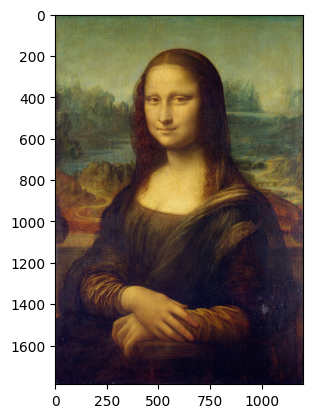

In [36]:
style_img = get_sample_image("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1200px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg", "content")
plt.imshow(style_img)

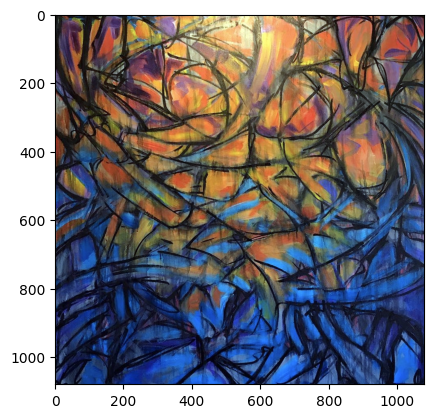

In [38]:
style_img = get_sample_image("https://veryprivategallery.com/wp-content/uploads/2019/02/Jason-Towne-2.jpg", "style")
plt.imshow(style_img)

In [39]:
model = Model().to(DEVICE)#Instantiating the model

/home/h4rzor/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/h4rzor/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
tensor_to_image = transforms.Compose([
        transforms.Lambda(lambda x: (x + 1) / 2),
        transforms.Lambda(lambda x: x.permute(1,2,0)),
        transforms.Lambda(lambda x: x * 255),
        transforms.Lambda(lambda x: x.numpy().astype(np.uint8)),
        transforms.ToPILImage()])
#Transforming the pictures and keeping the colors the same(very important, otherwise I've seen a blue lion)

In [47]:
EPOCHS = 4000
ALPHA = 1
BETA = 100
#Initializing the hyperparameters

generated = content.clone().requires_grad_(True)
#This will be the changed picture eventually. We're cloning it and set the requires_grad to True
# because we'd like to change the gradients of the picture

optimizer = torch.optim.Adam([generated], lr=0.01,betas=[0.5, 0.999])#Initializing adam 

**Here it is, the most important part of this model. The training.** </br>

- **First, we need to pass each and every image through the model. That is: content image, style image and cloned image.** </br>

- **Second, we start iterating over the lists generated from image passing through the model.** </br>

Generally each layer in the network defines a non-linear filter bank whose complexity increases with the position of the layer in the network. Hence a given input image $\overrightarrow x$ is encoded in each layer of the CNN by the filter responses to that image. A layer with $N_{l}$ distinct filters has $N_{l}$ feature maps each of size $M_{l}$, where $M_{l}$ is the height time the width of the feature map. So the responses in a layer $l$ can be stored in a matrix $F^{l} \in R^{N_{l}\times{M_{l}}}$ where $F_{ij}^{l}$ is the activation of the $i^{th}$ filter at position $j$ in layer $l$. To visualize the image information that is encoded at different layers of the hierarchy, we perform gradient descent on a white noise image to find another image that matches the feature responses of the original image. So let \overrightarrow p and \overrightarrow x be the original image and the image that is generated and $P^{l}$ and $F^{l}$ their respective feature representation in layer $l$.We then define the squared-error loss between the two feature representations: $\ell_{content}(\overrightarrow p, \overrightarrow x, l) = \frac{1}{2} \sum_{i,j}(F_{ij}^{l} - P_{ij}^{l}) ^ 2$ </br>The derivative of this loss with respect to the activations in layer $l$ equals: 

$ \frac {\partial \ell_{content}}{\partial F_{ij}^{l}} = \left\{ 
  \begin{array}{ c l }
    (F^{l} - P^{l})_{ij} & \quad \textrm{if } F_{ij}^{l} > 0 \\
    0                 & \quad \textrm{if } F_{ij}^{l} < 0
  \end{array}
\right. $
from which the gradient with respect to the image $\overrightarrow x$ can be computed using standard error back-propagation.

Feature correlations are given by the Gram matrix $G^{l} \in R^{N_{l}\times{M_{l}}}$, where $G_{ij}^{l}$ is the inner product between the vectorised feature map $i$ and $j$ in layer $l$: $G_{ij}^{l} = \sum_{k} F_{ik}^{l} F_{jk}^{l}$

To generate a texture that matches the style of a given image, we use gradient descent from a white noise image to find another image that matches the style representation of the original image. This is done by minimising the mean-squared distance
between the entries of the Gram matrix from the original image and the Gram matrix of the
image to be generated.

So let $\overrightarrow a$ and $\overrightarrow x$ be the original image and the image that is generated and $A^{l}$ and $G^{l}$ their respective style representations in layer $l$. The contribution of that layer to the total loss is then $E_{l} = \frac{1}{4N_{l}^{2}M_{l}^{2}} \sum_{i,j}(G_{ij}^{l} - A_{ij}^{l}) ^ 2$ and the total loss is: 
$\ell_{style}(\overrightarrow a, \overrightarrow x) = \sum_{l=0}^{L} w_{l}E_{l}$

To generate the images that mix the content of a photograph with the style of a painting we jointly minimise the distance of a white noise image from the content representation of the photograph in one layer of the network and the style representation of the painting in a
number of layers of the CNN. So let $\overrightarrow p$ be the photograph and $\overrightarrow a$ be the artwork. The loss function we minimise is: 
$\ell_{total}(\overrightarrow p, \overrightarrow a, \overrightarrow x) = \alpha \ell_{content}(\overrightarrow p, \overrightarrow x) + \beta \ell_{style}(\overrightarrow a, \overrightarrow x)$

In [48]:
def train_fun():
    for epoch in range(EPOCHS):
        content_loss = 0#Initializing the content loss
        style_loss = 0#Initializing the style loss
    
        content_features = model(content)#Propagating the content picture to the model
        style_features = model(style)#Propagating the style picture to the model
        generated_features = model(generated)#Propagating the cloned picture to the model
    
        for content_feature, style_feature, generated_feature in zip(content_features, style_features, generated_features):
            #This is a handy way to cycle through the three of the lists that we got
            
            content_loss += torch.mean((generated_feature - content_feature) ** 2)
            #Calculating the content loss by the formula
            

            channels, height, width = generated_feature.shape
            #Getting the channels, height and width of the cloned picture
            

            gram_matrix_style = style_feature.view(channels, height * width)
            #Getting ready for out style picture to be turned from 3D tensors
            # to 2D tensor in order to be later multiplied with some other 
            # 2D tensor in order to get the Gram matrix
            

            gram_matrix_generated = generated_feature.view(channels, height * width)
            #Same thing here, but for the cloned picture
            
            

            gram_matrix_style_result = torch.matmul(gram_matrix_style, gram_matrix_style.T)
            #Multiplying the gram matrices of the N layer in the style picture, then we're
            # going to subtract them from the cloned gram matrix product
            
        
            gram_matrix_generated_result = torch.matmul(gram_matrix_generated, gram_matrix_generated.T)
            #Multiplying the gram matrices from N layer of the cloned picture
            
            

            style_loss += torch.mean((gram_matrix_generated_result - gram_matrix_style_result) ** 2) / (channels * height * width)
            #Style loss is equal to the abs value of the two multiplied gram matrices divided by the dimensions
            # of the picture
            
            
        total_loss = (ALPHA * content_loss) + (BETA * style_loss)
        #Combining all the things, alpha and beta are hyperparameters which could be changed
        
        optimizer.zero_grad()#Zeroing out the gradients of the generator optimizer. It's a must before every cycle.
        total_loss.backward()#Computes the gradient of the current tensor - the 
        optimizer.step()#The simple way to do backward propagation, optimizer changes weights and biases here(learning)
        if epoch % 500 == 0:
            print(epoch)
            prediction = generated.detach().cpu()
            prediction = tensor_to_image(prediction)
            print(np.array(prediction).mean())
            plt.imshow(prediction)
            plt.show()
            #torchvision.utils.save_image(generated, 'output-{}.png'.format(epoch+1))

0
162.48198445638022


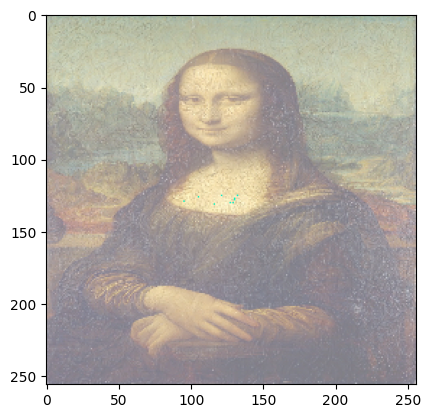

500
163.56524658203125


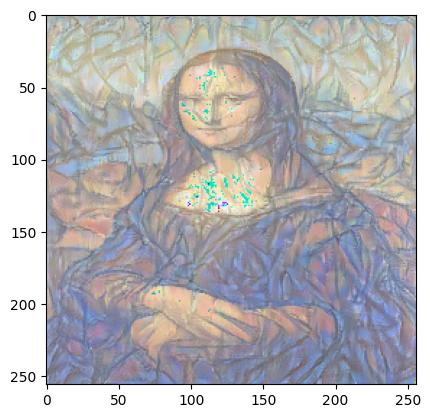

1000
163.72229512532553


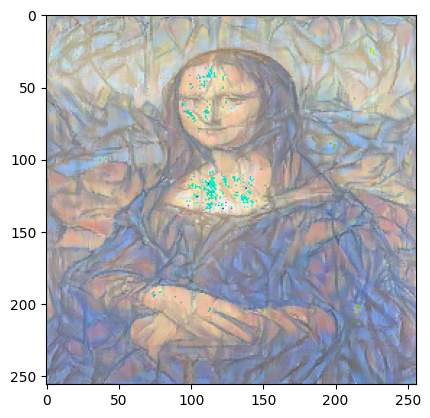

1500
163.75469462076822


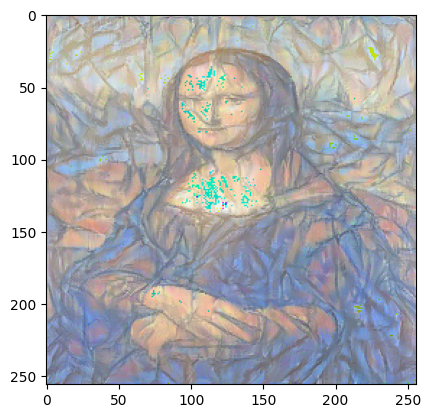

2000
163.74980672200522


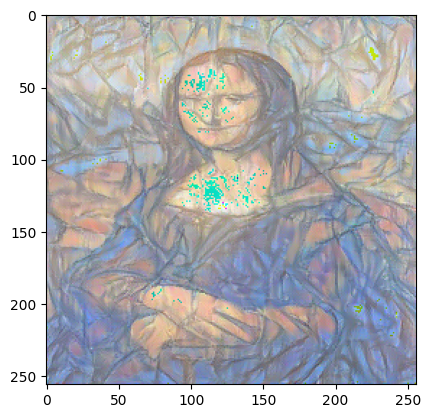

2500
163.85716756184897


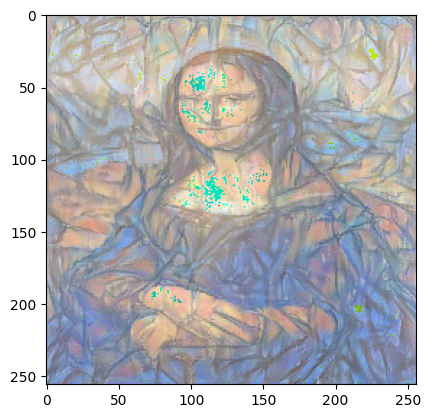

3000
163.92976888020834


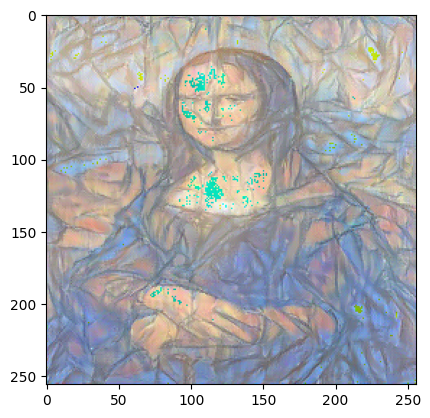

3500
164.0448964436849


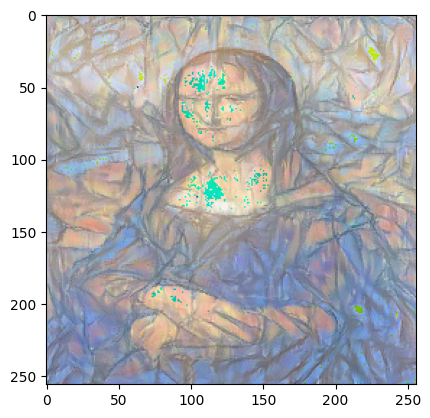

In [49]:
train_fun()